# Supervised Learning For Risk Classification, Diabetic Identification, and Smoker Identification

### By Ethan Clark and Riley Sayre
For CWRU Data Analytics Bootcamp 2023.

### Load Data

In [326]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


#  Import and read the cleaned_data_seriously_forrealthistime.csv.
import pandas as pd
application_df = pd.read_csv("Resources/cleaned_data__seriously_forrealthistime.csv")
application_df.head()

,index,PatientID,age,gender,bmi,bloodpressure,diabetic,children,smoker,region,claim
0,0,1,39,male,23.2,91,Yes,0,No,southeast,1121.87
1,1,2,24,male,30.1,87,No,0,No,southeast,1131.51
2,7,8,19,male,41.1,100,No,0,No,northwest,1146.80
3,8,9,20,male,43.0,86,No,0,No,northwest,1149.40
4,9,10,30,male,53.1,97,No,0,No,northwest,1163.46


## Exploratory Data Analysis

In [327]:
diab_check = application_df['diabetic'].value_counts()
diab_check

No     695
Yes    637
Name: diabetic, dtype: int64

### Region Analysis

In [405]:
region_df = application_df.drop(['index','PatientID'],axis=1)

In [406]:
region_df.groupby('region').agg(['mean','std','count'])

C:\Users\ethan\AppData\Local\Temp\ipykernel_9336\957404566.py:1: FutureWarning: ['gender', 'diabetic', 'smoker'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  region_df.groupby('region').agg(['mean','std','count'])


age                         bmi                  \
                mean        std count       mean       std count   
region                                                             
northeast  38.064935  11.587104   231  29.363203  5.967782   231   
northwest  37.707246  11.003360   345  29.202319  5.429821   345   
southeast  38.579186  10.987906   442  32.387104  6.578022   442   
southwest  37.824841  11.079060   314  30.777389  5.645261   314   

          bloodpressure                   children                  \
                   mean        std count      mean       std count   
region                                                               
northeast     95.722944  13.328992   231  1.017316  1.164569   231   
northwest     92.994203  10.125088   345  1.086957  1.165631   345   
southeast     94.398190  11.481812   442  1.097285  1.203563   442   
southwest     94.079618  11.166044   314  1.178344  1.281489   314   

                  claim                      
                   mean           std count  
region                                       
northeast  16889.044719  11578.101476   231  
northwest  11794.221855  11036.722585   345  
southeast  13085.496833  13179.731930   442  
southwest  12723.129841  11578.518764   314

Looks like the northeast is the leader in claim amounts with the least amount of subscribers. Would recommend pricing them separately with reduced benefits with an HSA.

Let's look at how the children are distributed

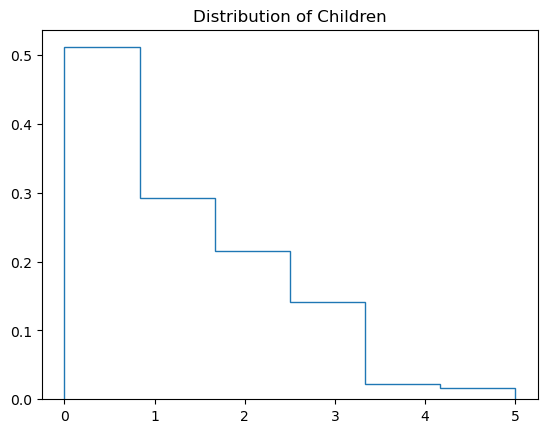

In [328]:

#Plotting the Distribution of Children
children_check = application_df['children'].value_counts()
n = children_check.nunique()
Ch_Hist = plt.hist(application_df['children'],bins=n,density=True,histtype="step",label="CDF of Children")
plt.title('Distribution of Children')
ax = plt.gca()
plt.show()

Let's do a spot check the relation between children and claim amounts

In [407]:
kid_df = application_df.drop(['index','PatientID'],axis=1)

In [408]:
kid_df.groupby('children').agg(['mean','std','count'])

C:\Users\ethan\AppData\Local\Temp\ipykernel_9336\3729892924.py:1: FutureWarning: ['gender', 'diabetic', 'smoker', 'region'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  kid_df.groupby('children').agg(['mean','std','count'])


age                         bmi                 bloodpressure  \
               mean        std count       mean       std count          mean   
children                                                                        
0         38.294014  10.927523   568  30.535563  6.087771   568     94.258803   
1         38.574074  11.192272   324  30.623765  6.099888   324     94.506173   
2         37.325000  11.449480   240  30.979167  6.509965   240     94.662500   
3         37.318471  11.091137   157  30.688535  5.787143   157     93.273885   
4         39.480000  10.770794    25  31.388000  4.629824    25     92.960000   
5         37.666667  12.160689    18  29.600000  7.145463    18     89.666667   

                                  claim                      
                std count          mean           std count  
children                                                     
0         11.814032   568  12484.987923  12030.479564   568  
1         11.019401   324  12731.171821  11823.631341   324  
2         11.416728   240  15073.564000  12891.368314   240  
3         11.881688   157  15355.318535  12330.869474   157  
4          7.231182    25  13850.656800   9139.223594    25  
5          7.420163    18   8786.035556   3808.434648    18

No crazy differences in claims amounts based on two tailed chernoff's inequality. Won't bore you with that!

Let's look at how age is distributed

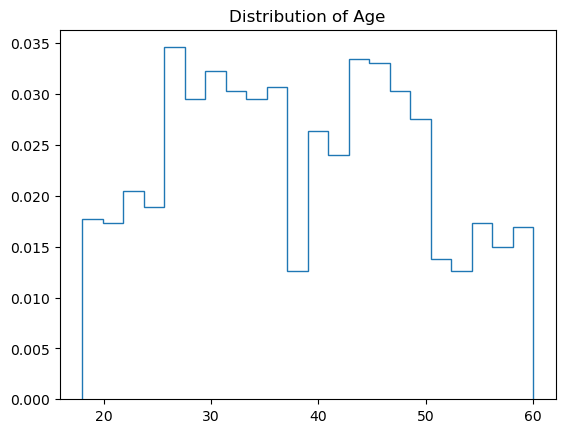

In [329]:
#Plotting the distribution of Age
age_check = application_df['age'].value_counts()
n = age_check.nunique()
Age_Hist = plt.hist(application_df['age'],bins=n,density=True,histtype="step")
plt.title('Distribution of Age')
axAge = plt.gca()
plt.show()

Let's check the overall claims distribution

In [330]:
# Look at claim value counts for binning
claim_amnts = application_df['claim'].value_counts()
m = claim_amnts.size

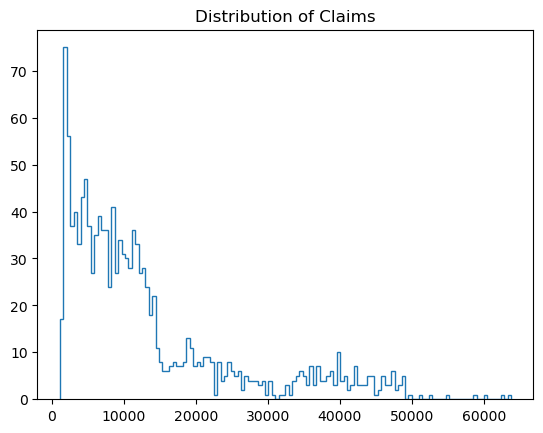

In [331]:
#Plotting the distribution of Claims
bin_count = int(m/10)
Claim_Hist = plt.hist(application_df['claim'],bins=bin_count,density=False,histtype="step")
plt.title('Distribution of Claims')
plt.show()

## Data Preprocessing

In [332]:
# Using get dummies on gender, diabetic, smoker, and region.
gen_dummies = pd.get_dummies(application_df['gender'],)
diab_dummies = pd.get_dummies(application_df['diabetic'],prefix='Diabetic?')
smonk_dummies = pd.get_dummies(application_df['smoker'],prefix='Smoker?')
region_dumies = pd.get_dummies(application_df['region'])

In [333]:
# dropping the columns used for dummies, Patient ID and Index then concatenating the new dummies columns on
drop_df = application_df.drop(['gender','diabetic','smoker','region','index','PatientID'],axis=1)
drop_df.head()

,age,bmi,bloodpressure,children,claim
0,39,23.2,91,0,1121.87
1,24,30.1,87,0,1131.51
2,19,41.1,100,0,1146.80
3,20,43.0,86,0,1149.40
4,30,53.1,97,0,1163.46


In [334]:
#Add the Dummies in
clean_df = pd.concat([drop_df,gen_dummies,diab_dummies,smonk_dummies,region_dumies],axis=1)
#Round the claim amounts to the dollar
clean_df = clean_df.astype({'claim':'int'})
#Check the Df
clean_df.head()

,age,bmi,bloodpressure,children,claim,female,male,Diabetic?_No,Diabetic?_Yes,Smoker?_No,Smoker?_Yes,northeast,northwest,southeast,southwest
0,39,23.2,91,0,1121,0,1,0,1,1,0,0,0,1,0
1,24,30.1,87,0,1131,0,1,1,0,1,0,0,0,1,0
2,19,41.1,100,0,1146,0,1,1,0,1,0,0,1,0,0
3,20,43.0,86,0,1149,0,1,1,0,1,0,0,1,0,0
4,30,53.1,97,0,1163,0,1,1,0,1,0,0,1,0,0


In [335]:
# Determine the number of unique values in each column.
categories = clean_df.dtypes.index.tolist()
clean_df[categories].nunique()

age                43
bmi               275
bloodpressure      61
children            6
claim            1278
female              2
male                2
Diabetic?_No        2
Diabetic?_Yes       2
Smoker?_No          2
Smoker?_Yes         2
northeast           2
northwest           2
southeast           2
southwest           2
dtype: int64

In [336]:
# Making Risk Bands For Clustering
[Risk1,Risk2] = np.around(clean_df['claim'].quantile([0.50,0.95]),decimals=2,out=None)
print([Risk1,Risk2])

[9412.5, 41350.8]


## Claims Risk Clustering

### 3 Risk Class Bin Structure

In [369]:
# Displaying Bin Structure
RiskMatrix = pd.DataFrame({'Low Risk':[Risk1,'0 - '+str(Risk1),0,1],
                            'Medium Risk':[Risk2,str(Risk1)+' - '+str(Risk2),Risk1,2],
                            'High Risk':['inf',str(Risk2)+' - '+'inf',Risk2,3]},
                            index=['Claims Under','Claims Between','Claims Over','Cluster #'])

RiskMatrix


,Low Risk,Medium Risk,High Risk
Claims Under,9412.5,41350.8,inf
Claims Between,0 - 9412.5,9412.5 - 41350.8,41350.8 - inf
Claims Over,0,9412.5,41350.8
Cluster #,1,2,3


### 2 Risk Class Bin Structure

In [370]:
# Displaying Bin Structure
RiskMatrix2 = pd.DataFrame({'Low Risk':[Risk1,'0 - '+str(Risk1),0,1],
                            'High Risk':['inf',str(Risk1)+' - '+'inf',Risk1,2]},
                            index=['Claims Under','Claims Between','Claims Over','Cluster #'])

RiskMatrix2

,Low Risk,High Risk
Claims Under,9412.5,inf
Claims Between,0 - 9412.5,9412.5 - inf
Claims Over,0,9412.5
Cluster #,1,2


### Claim Bin Functions

In [338]:
#Claim classifying functions
def Risk_Classify3 (x):
    if x <= Risk1:
        y = 1
    elif x <= Risk2:
        y = 2
    else:
        y = 3
    return (y)

def Risk_Classify2 (x):
    if x <= Risk1:
        y = 1
    else:
        y = 2
    return (y)

### DataFrame Copying & Splitting 

In [339]:
#Classifying Claim amounts into the three clusters
#copy to a new dataframe
train_df3 = clean_df.copy()
train_df3['claim'] = train_df3['claim'].apply(Risk_Classify3)
train_df3.head()

,age,bmi,bloodpressure,children,claim,female,male,Diabetic?_No,Diabetic?_Yes,Smoker?_No,Smoker?_Yes,northeast,northwest,southeast,southwest
0,39,23.2,91,0,1,0,1,0,1,1,0,0,0,1,0
1,24,30.1,87,0,1,0,1,1,0,1,0,0,0,1,0
2,19,41.1,100,0,1,0,1,1,0,1,0,0,1,0,0
3,20,43.0,86,0,1,0,1,1,0,1,0,0,1,0,0
4,30,53.1,97,0,1,0,1,1,0,1,0,0,1,0,0


In [340]:
#Classifying Claim amounts into the two clusters
#copy to a new dataframe
train_df2 = clean_df.copy()
train_df2['claim'] = train_df2['claim'].apply(Risk_Classify2)
train_df2.head()

,age,bmi,bloodpressure,children,claim,female,male,Diabetic?_No,Diabetic?_Yes,Smoker?_No,Smoker?_Yes,northeast,northwest,southeast,southwest
0,39,23.2,91,0,1,0,1,0,1,1,0,0,0,1,0
1,24,30.1,87,0,1,0,1,1,0,1,0,0,0,1,0
2,19,41.1,100,0,1,0,1,1,0,1,0,0,1,0,0
3,20,43.0,86,0,1,0,1,1,0,1,0,0,1,0,0
4,30,53.1,97,0,1,0,1,1,0,1,0,0,1,0,0


In [350]:
train_df3['claim'].value_counts()

1    666
2    599
3     67
Name: claim, dtype: int64

In [349]:
train_df2['claim'].value_counts()

1    666
2    666
Name: claim, dtype: int64

In [362]:
# Split our preprocessed data into our features and target arrays
yy2 = train_df2['claim']
xx2 = train_df2.drop(['claim'],axis=1)

# Split the preprocessed data into a training and testing dataset
X_train2,X_test2,Y_train2,Y_test2 = train_test_split(xx2,yy2,random_state=0)

In [ ]:
# Split our preprocessed data into our features and target arrays
yy3 = train_df3['claim']
xx3 = train_df3.drop(['claim'],axis=1)

# Split the preprocessed data into a training and testing dataset
X_train3,X_test3,Y_train3,Y_test3 = train_test_split(xx3,yy3,random_state=0)

### Compile, Train and Evaluate the Model (3 Risk Classes)

In [344]:
#Now time to run the classification model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, classification_report

logReg3 = LogisticRegression(random_state=0)
LogRegModel3 = logReg3.fit(X_train3,Y_train3)

c:\Users\ethan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [345]:
#Making Predictions
predictions3 = LogRegModel.predict(X_test3)

In [346]:
#printing accuracy and such
accuracy3 = balanced_accuracy_score(Y_test3,predictions3)
print(accuracy3)

0.5612389424018122


In [347]:
matrix3  = confusion_matrix(Y_test3,predictions3)
print(matrix3)

[[156  17   0]
 [ 46  95   2]
 [  0  15   2]]


In [348]:
classif3 = classification_report(Y_test3,predictions3)
print(classif3)

              precision    recall  f1-score   support

           1       0.77      0.90      0.83       173
           2       0.75      0.66      0.70       143
           3       0.50      0.12      0.19        17

    accuracy                           0.76       333
   macro avg       0.67      0.56      0.58       333
weighted avg       0.75      0.76      0.74       333



### Limitations of Data for 3 Risk Classes

The dataset does not include any underwriting information asides from smoking and diabetic statuses. To truly predict the High Cost Claimants, we need to have diagnosis data such as cancer or thalassemia and or pharmacy spend data for each patient.

### Compile, Train and Evaluate the Model (2 Risk Classes)

In [363]:
#Now time to run the classification model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, classification_report

logReg2 = LogisticRegression(random_state=0)
LogRegModel2 = logReg2.fit(X_train2,Y_train2)

c:\Users\ethan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [364]:
#Making Predictions
predictions2 = LogRegModel.predict(X_test2)

In [365]:
#printing accuracy and such
accuracy2 = balanced_accuracy_score(Y_test2,predictions2)
print(accuracy2)

0.7946170520231214


c:\Users\ethan\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


In [366]:
matrix2  = confusion_matrix(Y_test2,predictions2)
print(matrix2)

[[156  17   0]
 [ 46 110   4]
 [  0   0   0]]


In [367]:
classif2 = classification_report(Y_test2,predictions2)
print(classif2)

              precision    recall  f1-score   support

           1       0.77      0.90      0.83       173
           2       0.87      0.69      0.77       160
           3       0.00      0.00      0.00         0

    accuracy                           0.80       333
   macro avg       0.55      0.53      0.53       333
weighted avg       0.82      0.80      0.80       333



c:\Users\ethan\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ethan\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ethan\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Limitations of Data for 2 Risk Classes

The same reasons here, except this model will be much more effective for identifying high or low risk due to the higher amount of test data in each cluster. It ran a balanced accuracy of 79% compared to the 3 group model of 56%.
The dataset does not include any underwriting information asides from smoking and diabetic statuses. To truly predict the High Cost Claimants, we need to have diagnosis data such as cancer or thalassemia and or pharmacy spend data for each patient.

## Diabetic Identification Clustering

In [373]:
# Checking the DataFrame is ready to cluster directly
clean_df.head()

,age,bmi,bloodpressure,children,claim,female,male,Diabetic?_No,Diabetic?_Yes,Smoker?_No,Smoker?_Yes,northeast,northwest,southeast,southwest
0,39,23.2,91,0,1121,0,1,0,1,1,0,0,0,1,0
1,24,30.1,87,0,1131,0,1,1,0,1,0,0,0,1,0
2,19,41.1,100,0,1146,0,1,1,0,1,0,0,1,0,0
3,20,43.0,86,0,1149,0,1,1,0,1,0,0,1,0,0
4,30,53.1,97,0,1163,0,1,1,0,1,0,0,1,0,0


In [374]:
#Splitting the Data on Diabetic?_Yes
#Copy the DataFrame
diab_df = clean_df.copy()
# Split our preprocessed data into our features and target arrays
yyD = diab_df['Diabetic?_Yes']
xxD = diab_df.drop(['Diabetic?_No','Diabetic?_Yes'],axis=1)

# Split the preprocessed data into a training and testing dataset
X_trainD,X_testD,Y_trainD,Y_testD = train_test_split(xxD,yyD,random_state=0)

In [375]:
#Initialize the model
logRegD = LogisticRegression(random_state=0)
LogRegModelD = logRegD.fit(X_trainD,Y_trainD)

In [376]:
#Making Predictions
predictionsD = LogRegModelD.predict(X_testD)

In [377]:
#printing accuracy and such
accuracyD = balanced_accuracy_score(Y_testD,predictionsD)
print(accuracyD)

0.47375541125541126


In [378]:
matrixD  = confusion_matrix(Y_testD,predictionsD)
print(matrixD)

[[120  45]
 [131  37]]


In [379]:
classifD = classification_report(Y_testD,predictionsD)
print(classifD)

              precision    recall  f1-score   support

           0       0.48      0.73      0.58       165
           1       0.45      0.22      0.30       168

    accuracy                           0.47       333
   macro avg       0.46      0.47      0.44       333
weighted avg       0.46      0.47      0.44       333



### Diabetic Clustering Limitations

Since being a diabetic causes a large increase in pharmacy spend and increased risk of medical comorbidities, this data set is not extensive enough to effectly predict. We would need what their drug spend is and what types of claims they made over the time period (retinopathy and etcetera). However, an accuracy of 47% when constrained by HIPAA and the lack of underwriting information is still an astounding rate and may help anyone with proper medical insurance administration via suggestions for testing. Especially considering, someone may not know if they are diabetic or are at a higher risk. Let's compare the claims between diabetics and non-diabetics:

In [392]:
clean_df.groupby(by='Diabetic?_Yes').mean()['claim']

Diabetic?_Yes
0    13406.117986
1    13235.990581
Name: claim, dtype: float64

The similarity in Diabetic vs. Non-Diabetic claims confirms the data limitations!

## Smoker Identification Clustering

In [380]:
# Checking the DataFrame is ready to cluster directly
clean_df.head()

,age,bmi,bloodpressure,children,claim,female,male,Diabetic?_No,Diabetic?_Yes,Smoker?_No,Smoker?_Yes,northeast,northwest,southeast,southwest
0,39,23.2,91,0,1121,0,1,0,1,1,0,0,0,1,0
1,24,30.1,87,0,1131,0,1,1,0,1,0,0,0,1,0
2,19,41.1,100,0,1146,0,1,1,0,1,0,0,1,0,0
3,20,43.0,86,0,1149,0,1,1,0,1,0,0,1,0,0
4,30,53.1,97,0,1163,0,1,1,0,1,0,0,1,0,0


In [381]:
#Splitting the Data on Diabetic?_Yes
#Copy the DataFrame
smonk_df = clean_df.copy()
# Split our preprocessed data into our features and target arrays
yyS = smonk_df['Smoker?_Yes']
xxS = smonk_df.drop(['Smoker?_No','Smoker?_Yes'],axis=1)

# Split the preprocessed data into a training and testing dataset
X_trainS,X_testS,Y_trainS,Y_testS = train_test_split(xxS,yyS,random_state=0)

In [382]:
#Initialize the model
logRegS = LogisticRegression(random_state=0)
LogRegModelS = logRegS.fit(X_trainS,Y_trainS)

In [383]:
#Making Predictions
predictionsS = LogRegModelS.predict(X_testS)

In [384]:
#printing accuracy and such
accuracyS = balanced_accuracy_score(Y_testS,predictionsS)
print(accuracyS)

0.8541478129713425


In [385]:
matrixS  = confusion_matrix(Y_testS,predictionsS)
print(matrixS)

[[246   9]
 [ 20  58]]


In [386]:
classifS = classification_report(Y_testS,predictionsS)
print(classifS)

              precision    recall  f1-score   support

           0       0.92      0.96      0.94       255
           1       0.87      0.74      0.80        78

    accuracy                           0.91       333
   macro avg       0.90      0.85      0.87       333
weighted avg       0.91      0.91      0.91       333



### Smoking Clustering Limitations

This model is very accurate with a balanced accuracy of 85% with very few features involved. This can be applied pretty safely for EAP programs to target cessation support and screenings for cancer. This will ameliorate the rate at which subscribers will get smoking related conditions. Moreover, smoking is a great risk feature to predict and to adjust accordingly. Let's compare the claims between smokers and non-smokers:

In [393]:
clean_df.groupby(by='Smoker?_Yes').mean()['claim']

Smoker?_Yes
0     8475.379962
1    32049.729927
Name: claim, dtype: float64

This confirms the analysis of smoking condition of claim amounts!